In [24]:
# словарь с вариантами алгоритмов

models_dict = dict()

In [3]:
## КОД С СЕМИНАРА

import numpy as np
import pandas as pd
import gym
from pogema import pogema_v0, GridConfig


class VectorObservationAndActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(VectorObservationAndActionWrapper, self).__init__(env)
        self.action_space = env.action_space
        obs_space = env.observation_space
        size = obs_space.shape
        new_size = 1 * size[1] * size[2]
        self.observation_space = gym.spaces.Box(
            low=np.zeros((new_size)),
            high=np.ones((new_size)),
            shape=(new_size,),
            dtype=obs_space.dtype,
        )

    def reset(self):
        observation, is_active = self.env.reset()
        return (
            observation[0][0].flatten(),
            is_active,
        )  # Возвращает наблюдение как одномерный вектор

    def step(self, action):
        # Упаковка действия в массив
        obs, reward, trancated, terminated, info = self.env.step([action])

        # Распаковка наблюдения, награды и флага завершения
        return obs[0][0].flatten(), reward[0], trancated[0], terminated[0], info[0]


# Определение конфигурации среды
grid_config = GridConfig(
    num_agents=1,  # количество агентов
    size=15,  # размер сетки
    density=0.4,  # плотность препятствий
    seed=2,  # зерно для генерации
    max_episode_steps=128,  # горизонт планирования
    obs_radius=3,  # радиус видимости
)

# Создание среды и обертывание ее
env = pogema_v0(grid_config=grid_config)
env = VectorObservationAndActionWrapper(env)

# Тестирование среды
obs = env.reset()
print("Начальное наблюдение в виде вектора:", len(obs[0]))

for _ in range(10):
    action = env.action_space.sample()  # Выбор случайного действия
    obs, reward, trancated, terminated, info = env.step(action)
    done = trancated | terminated
    print(f"Наблюдение: {obs}, Награда: {reward}, Завершено: {done}")
    if done:
        break

Начальное наблюдение в виде вектора: 49
Наблюдение: [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, За

/home/p1dg/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
class Reward_wrapper(gym.Wrapper):
    def __init__(self, env):
        super(Reward_wrapper, self).__init__(env)

    def step(self, action):
        obs, reward, truncated, terminated, info = self.env.step(action)
        target_coord = np.array(env.get_targets_xy())
        agent_coord = np.array(env.get_agents_xy())
        distance_to_target = np.linalg.norm(agent_coord[0] - target_coord[0])
        reward -= 0.1 * distance_to_target

        return obs, reward, truncated, terminated, info

    def reset(self):
        """Reset the environment and return the initial observation."""
        return self.env.reset()


env = Reward_wrapper(env)

# Тестирование среды
obs = env.reset()
print("Начальное наблюдение в виде вектора:", len(obs[0]))

for _ in range(3):
    action = env.action_space.sample()  # Выбор случайного действия
    obs, reward, trancated, terminated, info = env.step(action)
    done = trancated | terminated
    env.render()
    print(
        f"Наблюдение: {obs}, Награда: {reward}, Завершено: {done}, Положение агента {env.get_agents_xy()}, Положение цели {env.get_targets_xy()}, action {action}"
    )
    if done:
        break

Начальное наблюдение в виде вектора: 49
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 


In [6]:
## ФУНКЦИИ ОТРИСОВКИ ДАННЫХ
import matplotlib.pyplot as plt


def plot_metrics(statistics, label):
    epochs = []
    returns = []
    for stats in statistics:
        epoch = stats[0]
        metrics = stats[1]
        env_return = metrics["environment"]
        epochs.append(epoch)
        returns.append(env_return)
    plt.plot(epochs, returns, label=label)


def get_scores(data):
    result = []
    for i in range(len(data)):
        result.append([scores[1]["environment"] for scores in data[i]])
    return np.array(result)


def visualize_with_std(data, proportions, label="default"):
    # Расчет средних значений и стандартных отклоненийt
    means = {p: np.mean(get_scores(data[p]), axis=0) for p in proportions}
    stds = {p: np.std(get_scores(data[p]), axis=0) for p in proportions}

    for p in proportions:
        x = np.arange(1, len(means[p]) + 1)
        plt.plot(x, means[p], label=f"{label} - Mean of {p}")
        plt.fill_between(x, means[p] - stds[p], means[p] + stds[p], alpha=0.2)

    plt.title("Сравнение обучения на данных разного качества")

### Сбор эталонных данных


In [28]:
import torch
import d3rlpy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dqn = d3rlpy.algos.DQNConfig().create(device=DEVICE.type)
dqn_buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)
explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.4)

dqn.fit_online(env, dqn_buffer, explorer, n_steps=100, n_steps_per_epoch=5000)

2024-04-15 23:46.33 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-04-15 23:46.33 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-15 23:46.33 [info     ] Action size has been automatically determined. action_size=5
2024-04-15 23:46.33 [info     ] Directory is created at d3rlpy_logs/DQN_online_20240415234633
2024-04-15 23:46.33 [debug    ] Building model...             
2024-04-15 23:46.33 [debug    ] Model has been built.         
2024-04-15 23:46.33 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}

  0%|          | 0/100 [00:00<?, ?it/s]

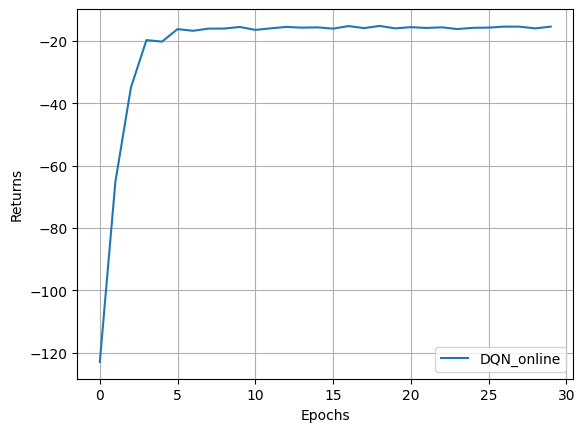

In [8]:
# вознаграждения
rollout_file = "./d3rlpy_logs/DQN_online_20240415231239/rollout_return.csv"
dt_statistics = pd.read_csv(rollout_file, header=None)

plt.plot(dt_statistics[2], label="DQN_online")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

### Сбор субоптимальных данных


In [ ]:
def dataset_with_terminals(buffer, size):
    observations = []
    actions = []
    rewards = []
    terminals = []

    for episode in buffer.episodes[:size]:
        observations += episode.observations.tolist()
        actions += episode.actions.tolist()
        rewards += episode.rewards.tolist()

        terminal = [0 for _ in range(len(episode.rewards))]
        terminal[-1] = 1
        terminals += terminal
    return observations, actions, rewards, terminals


def make_mixed_dataset(dataset_1, dataset_2, proportions=[1, 1]):
    size_1 = int(len(dataset_1.episodes) * proportions[0])
    size_2 = int(len(dataset_2.episodes) * proportions[1])

    observations, actions, rewards, terminals = dataset_with_terminals(
        dataset_1, size_1
    )
    rnd_observations, rnd_actions, rnd_rewards, rnd_terminals = dataset_with_terminals(
        dataset_2, size_2
    )

    mxt_obs = np.asarray(observations + rnd_observations)
    mxt_actions = np.asarray(actions + rnd_actions)
    mxt_rewards = np.asarray(rewards + rnd_rewards)
    mxt_terminals = np.asarray(terminals + rnd_terminals).reshape(-1, 1)

    mixed_dataset = d3rlpy.dataset.MDPDataset(
        observations=mxt_obs,
        actions=mxt_actions,
        rewards=mxt_rewards,
        terminals=mxt_terminals,
    )
    return mixed_dataset


mixed_data = make_mixed_dataset(dqn_buffer, random_buffer, (0.7, 0.3))

## Обучение Behavior Cloning (BC) на эталонных данных


In [17]:
bc = d3rlpy.algos.DiscreteBCConfig(learning_rate=1e-4, gamma=0.9).create(
    device=DEVICE.type
)

# start training
stat_bc = bc.fit(
    dqn_buffer,
    n_steps=100000,
    n_steps_per_epoch=7000,
    evaluators={
        "environment": d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-15 23:30.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-15 23:30.32 [info     ] Directory is created at d3rlpy_logs/DiscreteBC_20240415233032
2024-04-15 23:30.32 [debug    ] Building models...            
2024-04-15 23:30.33 [debug    ] Models have been built.       
2024-04-15 23:30.33 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0

Epoch 1/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:31.18 [info     ] DiscreteBC_20240415233032: epoch=1 step=7000 epoch=1 metrics={'time_sample_batch': 0.0032115023817334857, 'time_algorithm_update': 0.0031416777202061246, 'loss': 2.737477632522583, 'time_step': 0.006409356083188738, 'environment': -3.3950335179817124} step=7000
2024-04-15 23:31.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_7000.d3


Epoch 2/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:32.03 [info     ] DiscreteBC_20240415233032: epoch=2 step=14000 epoch=2 metrics={'time_sample_batch': 0.0031973349366869247, 'time_algorithm_update': 0.003114347321646554, 'loss': 2.736292501653944, 'time_step': 0.006367928164345877, 'environment': -3.3950335179817124} step=14000
2024-04-15 23:32.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_14000.d3


Epoch 3/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:32.49 [info     ] DiscreteBC_20240415233032: epoch=3 step=21000 epoch=3 metrics={'time_sample_batch': 0.0031780364172799246, 'time_algorithm_update': 0.0033678411075047086, 'loss': 2.736388548408236, 'time_step': 0.006599046230316162, 'environment': -3.3950335179817124} step=21000
2024-04-15 23:32.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_21000.d3


Epoch 4/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:33.36 [info     ] DiscreteBC_20240415233032: epoch=4 step=28000 epoch=4 metrics={'time_sample_batch': 0.0031784255845206124, 'time_algorithm_update': 0.0033936310155051096, 'loss': 2.735441062756947, 'time_step': 0.006626471144812448, 'environment': -3.3950335179817124} step=28000
2024-04-15 23:33.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_28000.d3


Epoch 5/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:34.23 [info     ] DiscreteBC_20240415233032: epoch=5 step=35000 epoch=5 metrics={'time_sample_batch': 0.0031848980699266706, 'time_algorithm_update': 0.0034034492288317, 'loss': 2.736058394772666, 'time_step': 0.0066438110555921285, 'environment': -3.3950335179817124} step=35000
2024-04-15 23:34.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_35000.d3


Epoch 6/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:35.10 [info     ] DiscreteBC_20240415233032: epoch=6 step=42000 epoch=6 metrics={'time_sample_batch': 0.0031995688165937152, 'time_algorithm_update': 0.0034313339846474785, 'loss': 2.734875467164176, 'time_step': 0.006687385218484061, 'environment': -3.3950335179817124} step=42000
2024-04-15 23:35.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_42000.d3


Epoch 7/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:35.56 [info     ] DiscreteBC_20240415233032: epoch=7 step=49000 epoch=7 metrics={'time_sample_batch': 0.0032329065118517197, 'time_algorithm_update': 0.0031488522802080427, 'loss': 2.735562161173139, 'time_step': 0.006441874061311994, 'environment': -3.3950335179817124} step=49000
2024-04-15 23:35.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_49000.d3


Epoch 8/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:36.43 [info     ] DiscreteBC_20240415233032: epoch=8 step=56000 epoch=8 metrics={'time_sample_batch': 0.003294830390385219, 'time_algorithm_update': 0.003404128006526402, 'loss': 2.7360327405929565, 'time_step': 0.0067614914349147254, 'environment': -3.3950335179817124} step=56000
2024-04-15 23:36.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_56000.d3


Epoch 9/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:37.31 [info     ] DiscreteBC_20240415233032: epoch=9 step=63000 epoch=9 metrics={'time_sample_batch': 0.0032723777294158935, 'time_algorithm_update': 0.0034478049278259277, 'loss': 2.736031610863549, 'time_step': 0.006785630055836269, 'environment': -3.3950335179817124} step=63000
2024-04-15 23:37.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_63000.d3


Epoch 10/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:38.17 [info     ] DiscreteBC_20240415233032: epoch=10 step=70000 epoch=10 metrics={'time_sample_batch': 0.003225605079105922, 'time_algorithm_update': 0.0032272628375462123, 'loss': 2.7365148312364305, 'time_step': 0.006514929362705776, 'environment': -3.3950335179817124} step=70000
2024-04-15 23:38.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_70000.d3


Epoch 11/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:39.03 [info     ] DiscreteBC_20240415233032: epoch=11 step=77000 epoch=11 metrics={'time_sample_batch': 0.0032211786678859166, 'time_algorithm_update': 0.0031611033167157853, 'loss': 2.7363908853190284, 'time_step': 0.00644371543611799, 'environment': -3.3950335179817124} step=77000
2024-04-15 23:39.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_77000.d3


Epoch 12/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:39.49 [info     ] DiscreteBC_20240415233032: epoch=12 step=84000 epoch=12 metrics={'time_sample_batch': 0.0032079057693481447, 'time_algorithm_update': 0.003288327727999006, 'loss': 2.7362384698050364, 'time_step': 0.006559238638196673, 'environment': -3.3950335179817124} step=84000
2024-04-15 23:39.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_84000.d3


Epoch 13/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:40.36 [info     ] DiscreteBC_20240415233032: epoch=13 step=91000 epoch=13 metrics={'time_sample_batch': 0.00323503463608878, 'time_algorithm_update': 0.003354092904499599, 'loss': 2.7353745396137237, 'time_step': 0.00665247791154044, 'environment': -3.3950335179817124} step=91000
2024-04-15 23:40.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_91000.d3


Epoch 14/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 23:41.22 [info     ] DiscreteBC_20240415233032: epoch=14 step=98000 epoch=14 metrics={'time_sample_batch': 0.0032076453821999686, 'time_algorithm_update': 0.0031984848294939316, 'loss': 2.735743948153087, 'time_step': 0.006467313528060913, 'environment': -3.3950335179817124} step=98000
2024-04-15 23:41.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415233032/model_98000.d3


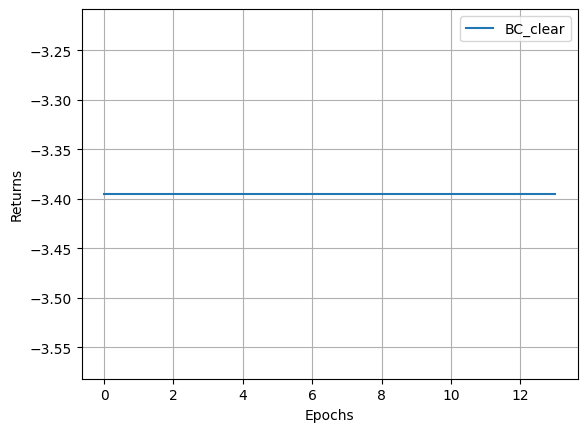

In [26]:
models_dict["BC_clear"] = [val[1]["environment"] for val in stat_bc]

plt.plot(models_dict["BC_clear"], label="BC_clear")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()